# Issue #1663 (Numpy)

In [1]:
import requests
import numpy as np
from PIL import Image
from io import BytesIO
import torch
import pandas as pd
import numpy as np
from torchvision.models import resnet

from art.estimators.classification.pytorch import PyTorchClassifier
from art.attacks.evasion import AdversarialPatchNumpy
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, Compose, transforms

import cv2
import matplotlib
import matplotlib.pyplot as plt

import PIL.Image
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

import os
import glob
import gzip
import pickle

plt.style.use('ggplot')
matplotlib.use( 'tkagg' )
%matplotlib inline

resnet.model_urls["resnet50"] = "https://download.pytorch.org/models/resnet50-11ad3fa6.pth"

'''
Predict top 5 classes for image
'''
def predict_model(classifier, image):
    plt.axis("off")
    plt.imshow(image.transpose(1,2,0))
    plt.show()

    predictions = classifier.predict(np.array([image]))
    predictions = torch.nn.functional.softmax(torch.Tensor(predictions), dim=1).numpy()

    top_5 = np.argsort(-predictions)[:, :5]

    for idx in top_5[0].tolist():
        print(label_to_name(idx)+':', predictions[0][idx])

#### Hyperparameters

In [2]:
target_name = 'goldfish, Carassius auratus'
image_shape = (3, 224, 224)
clip_values = (0, 1)
nb_classes  = 1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 50.
max_iter = 100

#### Model definition

In [3]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model.eval()

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

ptc = PyTorchClassifier(model=model, loss=torch.nn.CrossEntropyLoss(), nb_classes=nb_classes, 
                                        input_shape=image_shape, clip_values=clip_values,
                                        preprocessing=(MEAN, STD))

## ImageNet images

Load images, convert RGB to BGR. Further preprocessing passed to TensorFlowV2Classifier: zero-center each color channel with respect to ImageNet dataset [without scaling](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input#:~:text=The%20images%20are%20converted%20from%20RGB%20to%20BGR%2C%20then%20each%20color%20channel%20is%20zero%2Dcentered%20with%20respect%20to%20the%20ImageNet%20dataset%2C%20without%20scaling).

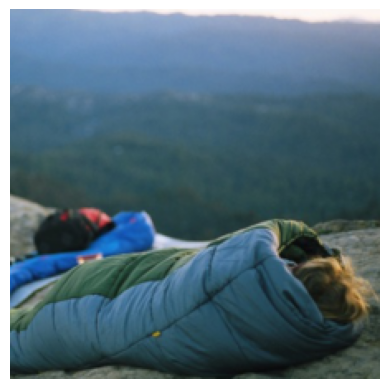

sleeping bag: 0.3727104
mountain tent: 0.02019634
binoculars, field glasses, opera glasses: 0.012218014
valley, vale: 0.008150697
volcano: 0.007430867


In [47]:
images_list = list()
preprocess = transforms.Compose([
        transforms.Resize(232),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])

for image_path in imagenet_stubs.get_image_paths():
    im = PIL.Image.open(image_path)
    im = preprocess(im).numpy()
    images_list.append(im)

images = np.array(images_list)

predict_model(ptc, images[0])

#### Generate Adversarial Patch

Adversarial Patch Numpy:   0%|          | 0/100 [00:00<?, ?it/s]

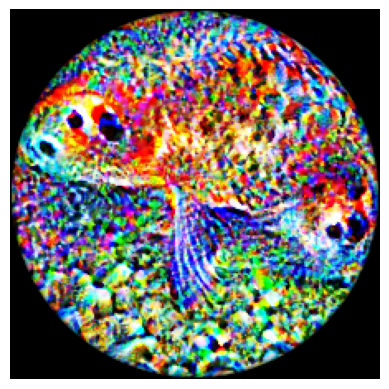

In [48]:
ap = AdversarialPatchNumpy(classifier=ptc, rotation_max=rotation_max, 
                      scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size)

label = name_to_label(target_name) 
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

plt.axis("off")
plt.imshow(((patch) * patch_mask).transpose(1,2,0))
plt.show()

#### Apply the adversarial patch to images

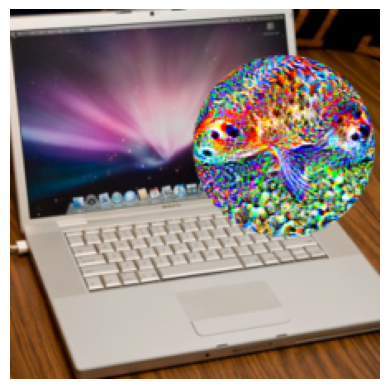

goldfish, Carassius auratus: 0.30135036
notebook, notebook computer: 0.13758248
laptop, laptop computer: 0.05825542
space bar: 0.028724477
computer keyboard, keypad: 0.028156916


In [49]:
patched_images = ap.apply_patch(images, scale=0.5)
predict_model(ptc, patched_images[-1])